# 1. Importing Libraries

In [201]:
# Importing Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import transforms
from torchmetrics import Accuracy
from torchinfo import summary
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

# 2. Setting up the device

In [202]:
# Setting Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

mps


# 3. Preparing the test_data

In [203]:
# Preparing Input Data
# prepare the dataset MNIST(1x28x28) for LeNet
param_transform = transforms.Compose([
    transforms.Pad(2), # padding 2 pixels on each side
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # Normalize to [-1, 1] range
])

MNIST dataset information:
 - Number of training samples: 60000
 - Number of test samples: 10000
 - Image Shape: torch.Size([1, 32, 32])
 - Number of classes: 10
 - Samples number all classes: tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train


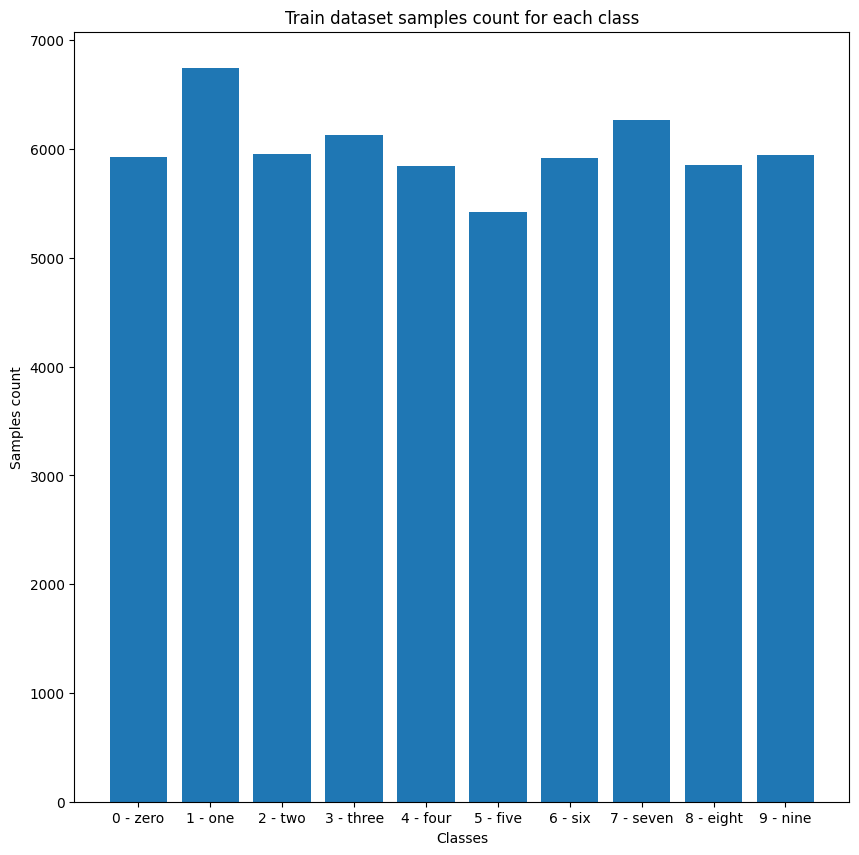

Test dataset:
 - Number of datapoints: 10000
 - Image Shape: torch.Size([1, 32, 32])
 - Number of classes: 10
 - Samples number all classes: tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


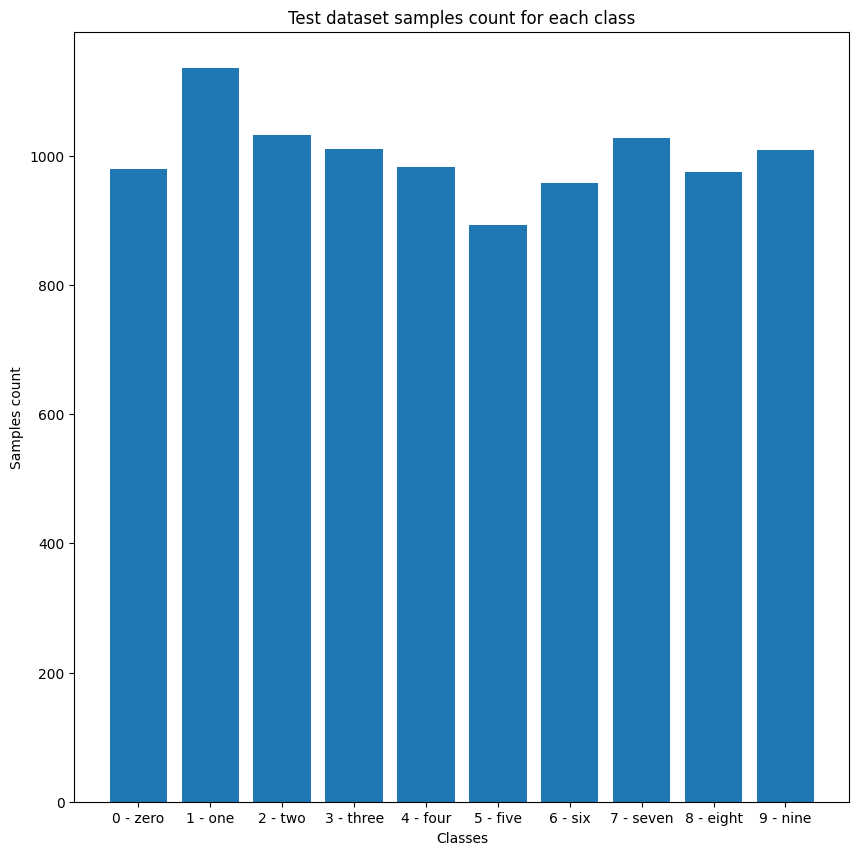

In [204]:
# Load the dataset
test_data = datasets.MNIST(
    root='./dataset', 
    train=False, 
    transform=param_transform, 
    download=True)

test_data_info = datasets.MNIST(
    root='./dataset', 
    train=True,
    download=False)
print("MNIST dataset information:")
print(" - Number of training samples: {}".format(len(test_data_info)))
print(" - Number of test samples: {}".format(len(test_data)))
print(" - Image Shape: {}".format(test_data[0][0].shape))
print(" - Number of classes: {}".format(len(test_data.classes)))
print(" - Samples number all classes: {}".format(test_data.targets.bincount()))
# info about the dataset
print(test_data_info)

# plot the train dataset samples count for each class
fig = plt.figure(figsize=(10, 10))
plt.bar(test_data_info.classes, test_data_info.targets.bincount())
plt.title('Train dataset samples count for each class')
plt.xlabel('Classes')
plt.ylabel('Samples count')
plt.savefig('train_dataset_samples_count.png')
plt.show()

# Dataset summary
print('Test dataset:')
print(' - Number of datapoints: {}'.format(len(test_data)))
print(' - Image Shape: {}'.format(test_data[0][0].shape))
print(' - Number of classes: {}'.format(len(test_data.classes)))
print(" - Samples number all classes: {}".format(test_data.targets.bincount()))

# plot the test dataset samples count for each class
fig = plt.figure(figsize=(10, 10))
plt.bar(test_data.classes, test_data.targets.bincount())
plt.title('Test dataset samples count for each class')
plt.xlabel('Classes')
plt.ylabel('Samples count')
plt.savefig('test_dataset_samples_count.png')
plt.show()

In [205]:
# Dataset for visualization
# get the 10 images from the test set for visualization
vis_size = 10
test_data_vis = torch.utils.data.Subset(test_data, range(vis_size))

# Dataset summary
print('Test dataset for visualization:')
print(' - Number of datapoints: {}'.format(len(test_data_vis)))
print(' - Image Shape: {}'.format(test_data_vis[0][0].shape))

# loader
test_loader_vis = DataLoader(test_data_vis, batch_size=vis_size, shuffle=True)

Test dataset for visualization:
 - Number of datapoints: 10
 - Image Shape: torch.Size([1, 32, 32])


In [206]:
# Create dataloaders
if torch.cuda.is_available():
    BATCH_SIZE = 128
elif torch.backends.mps.is_available():
    BATCH_SIZE = 128
else:
    BATCH_SIZE = 64
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Dataloader summary
print('Test dataloader:')
print(' - Number of batches: {}'.format(len(test_loader)))

Test dataloader:
 - Number of batches: 79


# 4. Loading the model

In [207]:
# Defining Model
# LeNet-5 architecture implementation
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extractor
        self.feature = nn.Sequential(
            # Convolutional layers
            
            # ============================================================================== #
            # First conv layer
            # input: 1 x 28 x 28 --> padding = 2 --> 1 x 32 x 32 --> 6 x 28 x 28
            #nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            # activation function
            nn.Tanh(),
            # pooling layer 14 x 14
            nn.AvgPool2d(kernel_size=2, stride=2),
            # ============================================================================== #
            
            # ============================================================================== #
            # Second conv layer
            # input: 6 x 14 x 14 --> 16 x 10 x 10
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            # activation function
            nn.Tanh(),
            # pooling layer 5 x 5
            nn.AvgPool2d(kernel_size=2, stride=2),
            # ============================================================================== #
        )

        # Classifier
        self.classifier = nn.Sequential(
            # Fully connected layers
            
            # ============================================================================== #
            # First fc layer
            # input: 16 x 5 x 5 = 400 --> 120
            # flatten
            nn.Flatten(),
            # fc layer
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            # activation function
            nn.Sigmoid(), # sigmoid
            # ============================================================================== #

            # ============================================================================== #
            # Second fc layer
            nn.Linear(in_features=120, out_features=84),

            # activation function
            nn.Sigmoid(), # sigmoid
            # ============================================================================== #
            
            # ============================================================================== #
            # Third fc layer
            nn.Linear(in_features=84, out_features=10),
            # ============================================================================== #
            nn.Softmax(dim=1)
        )

    # Forward function
    def forward(self, x):
        return self.classifier(self.feature(x))

In [208]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

In [209]:
# Log the test
date_time = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

In [210]:
MODE = "multiple_tests"
if MODE == "single_test":
    # Load the model
    model = LeNet5().to(device)
    print(model)
    # Load the model weights
    model_name = 'LeNet5_v1_2024_01_07-09_31_56.pth'
    model.load_state_dict(torch.load(os.path.join('models', model_name), map_location=device))
    # Model summary
    #summary(model, input_size=(1, 1, 28, 28), verbose=2, device=device)
    summary(model, input_size=(1, 1, 32, 32), verbose=2, device=device)
    # Calculate model weights size
    model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Model size: {model_size} parameters')
    print('Model weights size: {:.2f} MB'.format(sum(p.numel() for p in model.parameters())/(1024*1024)))
    # Set the model to evaluation mode
    model.eval()
    
    # Create the log directory
    test_folder_name = f"test_{model_name}_{date_time}"
    log_dir = os.path.join('test_logs', test_folder_name)
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)

elif MODE == "multiple_tests":
    models_lst = os.listdir('models')
    models_lst.sort()
    print(models_lst)
    # create the log directory
    test_folder_name = f"test_{date_time}"
    log_dir = os.path.join('test_logs', test_folder_name)
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)

['LeNet5_v1_2024_01_07-21_50_10.pth', 'LeNet5_v2_2024_01_07-21_50_10.pth', 'LeNet5_v3_2024_01_07-21_50_10.pth', 'LeNet5_v4_2024_01_07-21_50_10.pth']


In [211]:
# Test the model
y_true = []
y_pred = []
if MODE == "single_test":
    with torch.no_grad():
        acc_tmp = []
        loss_tmp = []
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move the data to device
            data = data.to(device)
            target = target.to(device)
    
            # Forward pass
            output = model(data)
            loss = loss_fn(output, target)
            acc = accuracy(output, target)
            
            # save the loss and accuracy
            loss_tmp.append(loss.item())
            acc_tmp.append(acc.item())
            
            # save the true and predicted labels for confusion matrix
            y_true.extend(target.cpu().numpy())
            y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
    
            # Print the loss and accuracy
            if batch_idx % 10 == 0:
                print('Test Batch {}/{}: Loss: {:.6f}, Accuracy: {:.6f}'.format(
                    batch_idx, len(test_loader), loss.item(), acc.item()))
                
        # Calculate the average loss and accuracy
        avg_loss = sum(loss_tmp)/len(loss_tmp)
        avg_acc = sum(acc_tmp)/len(acc_tmp)
        print('Test: Average Loss: {:.6f}, Average Accuracy: {:.6f}'.format(avg_loss, avg_acc))
        writer.add_scalar(tag="Accuracy", scalar_value=avg_acc, global_step=0)
        writer.add_scalar(tag="Loss", scalar_value=avg_loss, global_step=0)
elif MODE == "multiple_tests":
    acc_lst = []
    loss_lst = []
    for model_name in models_lst:
        # Load the model
        model = LeNet5().to(device)
        # Load the model weights
        model.load_state_dict(torch.load(os.path.join('models', model_name), map_location=device))
        # Model summary
        #summary(model, input_size=(1, 1, 28, 28), verbose=2, device=device)
        summary(model, input_size=(1, 1, 32, 32), verbose=2, device=device)
        # Calculate model weights size
        model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Model size: {model_size} parameters')
        print('Model weights size: {:.2f} MB'.format(sum(p.numel() for p in model.parameters())/(1024*1024)))
        # Set the model to evaluation mode
        model.eval()
        
        with torch.no_grad():
            acc_tmp = []
            loss_tmp = []
            y_true_tmp = []
            y_pred_tmp = []
            for batch_idx, (data, target) in enumerate(test_loader):
                # Move the data to device
                data = data.to(device)
                target = target.to(device)
        
                # Forward pass
                output = model(data)
                loss = loss_fn(output, target)
                acc = accuracy(output, target)
                
                # save the loss and accuracy
                loss_tmp.append(loss.item())
                acc_tmp.append(acc.item())
                
                # save the true and predicted labels for confusion matrix
                y_true_tmp.extend(target.cpu().numpy())
                y_pred_tmp.extend(torch.argmax(output, dim=1).cpu().numpy())
        
                # Print the loss and accuracy
                if batch_idx % 10 == 0:
                    print('Test Batch {}/{}: Loss: {:.6f}, Accuracy: {:.6f}'.format(
                        batch_idx, len(test_loader), loss.item(), acc.item()))
                    
            # add true and predicted labels to the main list
            y_true.append(y_true_tmp)
            y_pred.append(y_pred_tmp)
                
            # Calculate the average loss and accuracy
            avg_loss = (sum(loss_tmp)/len(loss_tmp))
            avg_acc = (sum(acc_tmp)/len(acc_tmp))*100
        print('Test: Average Loss: {:.6f}, Average Accuracy: {:.6f}'.format(avg_loss, avg_acc))
        # for each model add the accuracy and loss to the tensorboard so that we can compare them like a line
        acc_lst.append(avg_acc)
        loss_lst.append(avg_loss)
        
        # clean the GPU memory
        # clear cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()
        else:
            torch.empty_cache()
        # release the model from GPU memory
        model = None

    for i in range (len(models_lst)):
        writer.add_scalar(tag="Accuracy", scalar_value=acc_lst[i], global_step=int((i+1)*10))
        writer.add_scalar(tag="Loss", scalar_value=loss_lst[i], global_step=int((i+1)*10))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 5, 5]             --
│    └─0.weight                                                    ├─150
│    └─0.bias                                                      ├─6
│    └─3.weight                                                    ├─2,400
│    └─3.bias                                                      └─16
│    └─Conv2d: 2-1                       [1, 6, 28, 28]            156
│    │    └─weight                                                 ├─150
│    │    └─bias                                                   └─6
│    └─Tanh: 2-2                         [1, 6, 28, 28]            --
│    └─AvgPool2d: 2-3                    [1, 6, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 16, 10, 10]           2,416
│    │    └─weight                                                

[[ 968    0    0    0    1    0    1    1    3    6]
 [   0 1126    2    0    1    0    1    2    3    0]
 [   0    1 1012    5    3    0    0    7    4    0]
 [   0    0    1  997    0    1    0    4    5    2]
 [   0    0    0    0  979    0    0    0    1    2]
 [   3    0    0    7    0  877    2    1    0    2]
 [   4    2    0    0    6    1  941    0    4    0]
 [   0    4    3    1    0    0    0 1018    0    2]
 [   4    0    1    1    2    1    0    1  960    4]
 [   2    2    0    0   14    0    0    3    4  984]]
              precision    recall  f1-score   support

    0 - zero       0.99      0.99      0.99       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.99      0.98      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.97      1.00      0.98       982
    5 - five       1.00      0.98      0.99       892
     6 - six       1.00      0.98      0.99       958
   7 - seven       0.98      0.99   

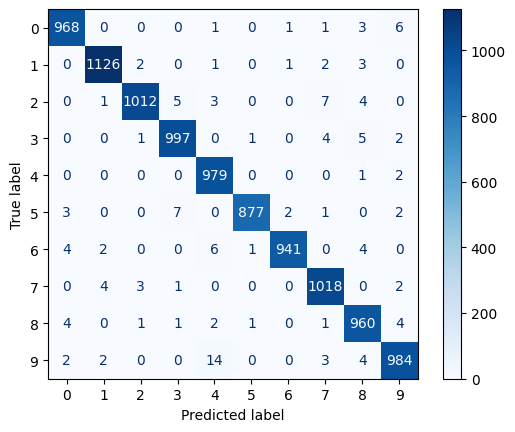

[[ 975    0    0    0    0    0    1    1    3    0]
 [   0 1125    1    0    0    1    3    4    1    0]
 [   2    1 1023    2    1    0    0    2    1    0]
 [   0    0    2 1004    0    0    0    1    0    3]
 [   0    0    0    0  972    0    3    0    0    7]
 [   2    0    0    3    0  883    3    1    0    0]
 [   4    1    0    0    1    2  950    0    0    0]
 [   0    3    4    2    0    0    0 1018    0    1]
 [   5    0    2    3    1    2    0    2  954    5]
 [   2    2    0    1    4    4    1    6    0  989]]
              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.99       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.98      0.99   

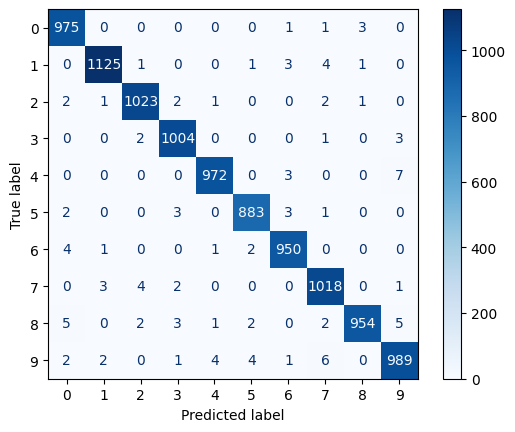

[[ 973    0    0    0    0    0    2    2    3    0]
 [   0 1132    0    0    0    1    1    1    0    0]
 [   2    2 1022    1    2    0    0    3    0    0]
 [   0    0    4 1000    0    1    0    1    3    1]
 [   0    0    0    0  977    0    3    0    0    2]
 [   2    0    1    7    0  878    2    1    0    1]
 [   2    3    1    0    3    1  946    0    2    0]
 [   0    4    5    4    0    0    0 1012    0    3]
 [   1    0    5    1    1    0    1    0  963    2]
 [   2    2    0    1    9    0    1    3    1  990]]
              precision    recall  f1-score   support

    0 - zero       0.99      0.99      0.99       980
     1 - one       0.99      1.00      0.99      1135
     2 - two       0.98      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.98      0.99      0.99       982
    5 - five       1.00      0.98      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.98   

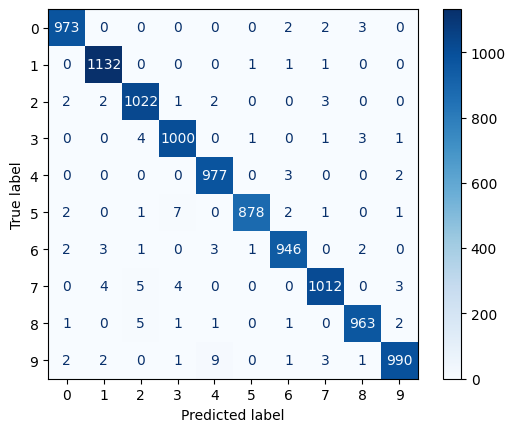

[[ 974    0    1    0    0    0    1    1    2    1]
 [   0 1129    1    0    0    2    1    2    0    0]
 [   1    2 1026    0    2    0    0    1    0    0]
 [   1    0    5  997    0    2    0    2    0    3]
 [   0    1    0    0  975    0    4    0    1    1]
 [   2    0    0    4    0  884    2    0    0    0]
 [   3    1    1    0    0    2  949    0    2    0]
 [   0    2    6    1    0    0    0 1016    0    3]
 [   2    0    2    1    1    0    1    2  964    1]
 [   1    0    0    0    9    3    1    5    5  985]]
              precision    recall  f1-score   support

    0 - zero       0.99      0.99      0.99       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.98      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.99   

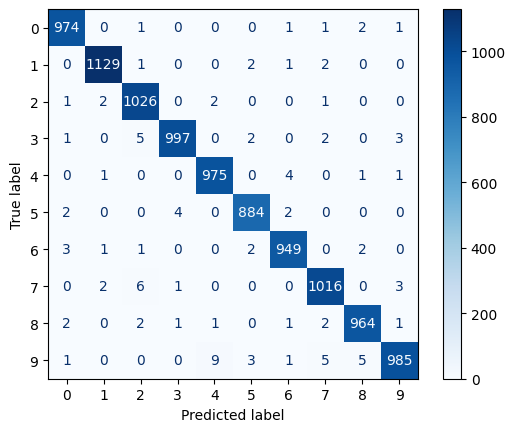

In [212]:
# Confusion matrix all test data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

if MODE == "single_test":
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    # Classification report
    print(classification_report(y_true, y_pred, target_names=test_data.classes))
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(os.path.join(log_dir, 'confusion_matrix.png'))
    plt.show()
    with open(os.path.join(log_dir, 'classification_report.txt'), 'w') as f:
        f.write(classification_report(y_true, y_pred, target_names=test_data.classes))
elif MODE == "multiple_tests":
    for i in range(len(models_lst)):
        # Confusion matrix
        cm = confusion_matrix(y_true[i], y_pred[i])
        print(cm)
        # Classification report
        print(classification_report(y_true[i], y_pred[i], target_names=test_data.classes))
        # Plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.savefig(os.path.join(log_dir, f'confusion_matrix_{models_lst[i]}.png'))
        plt.show()
        with open(os.path.join(log_dir, f'classification_report_{models_lst[i]}.txt'), 'w') as f:
            f.write(classification_report(y_true[i], y_pred[i], target_names=test_data.classes))
            f.write('\n')
            f.write('Confusion matrix:\n')
            f.write(str(cm))
    


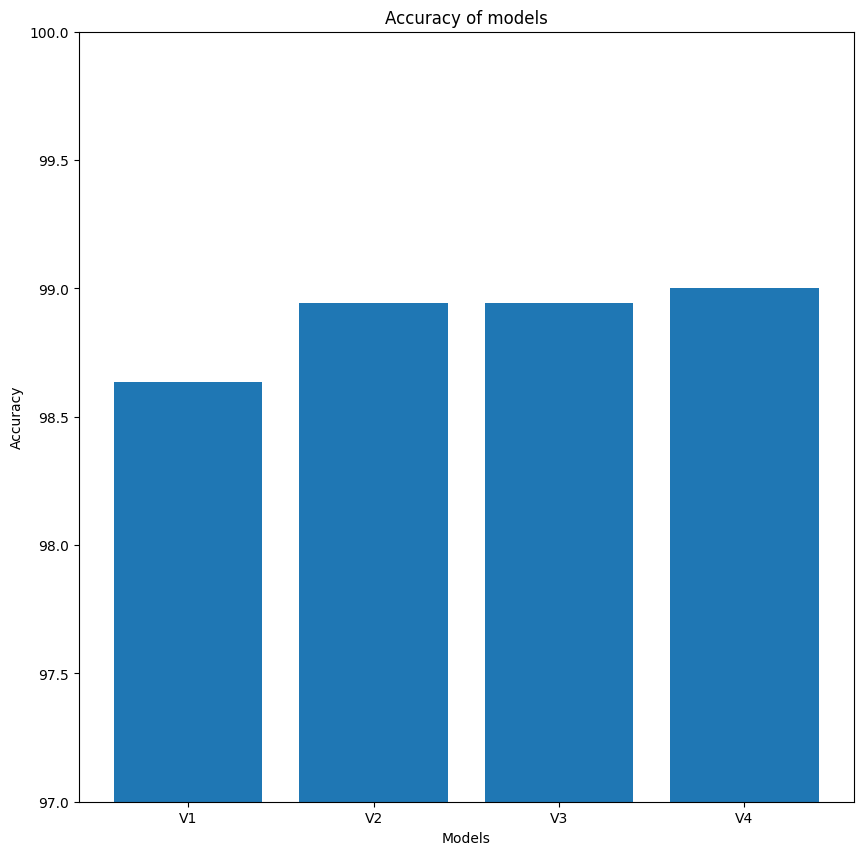

In [213]:
# Visualize the bar chart accuracy of models, V1, V2, V3, V4 (range 97-100%)
if MODE == "multiple_tests":
    labels = ['V1', 'V2', 'V3', 'V4']
    fig = plt.figure(figsize=(10, 10))
    plt.bar(labels, acc_lst)
    plt.title('Accuracy of models')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(97, 100)
    plt.savefig(os.path.join(log_dir, 'accuracy_models.png'))
    plt.show()

In [214]:
# Close the writer
writer.flush()
writer.close()

In [215]:
# Release GPU memory cache
# clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()
else:
    torch.empty_cache()

# Release model from GPU memory
model = None

# release all loaded data
data_vis = None
target_vis = None
data = None
target = None
data_loader = None
data_loader_vis = None
test_data = None
test_data_vis = None
test_loader = None
test_loader_vis = None

print('Done!')

Done!
